In [10]:
from transformers import pipeline
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [11]:
# Use a pipeline as a high-level helper
pipe = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

In [12]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [13]:
df_val = pd.read_csv("offenseval_val.csv")

In [14]:
# Предобработка текста с использованием токенизатора
texts = df_val['text'].tolist()
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")


In [15]:
# Предсказание с использованием модели
with torch.no_grad():
    outputs = model(**inputs)

In [16]:
# Извлечение классов
predictions = torch.argmax(outputs.logits, dim=1).tolist()

In [21]:
# Истинные метки из df_val
true_labels = df_val['label'].tolist()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

In [23]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.51
Precision: 0.17
Recall: 0.11
F1 Score: 0.13


In [24]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

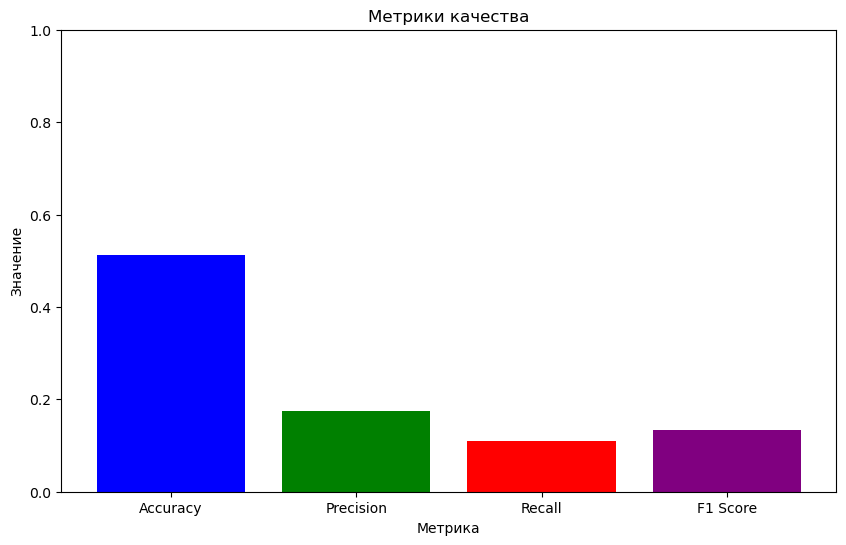

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Метрики качества')
plt.xlabel('Метрика')
plt.ylabel('Значение')
plt.ylim(0, 1)
plt.show()

In [83]:
from transformers import AdamW

In [100]:
# Загрузка обучающего набора данных
df_train = pd.read_csv("offenseval_train.csv")

In [101]:
# Преобразование текстовых данных и меток в тензоры
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()

In [94]:
# Токенизация и конвертация в тензоры
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
labels = torch.tensor(labels)

In [95]:
# Создание TensorDataset
dataset = TensorDataset(inputs.input_ids, inputs.attention_mask, labels)

In [96]:
# Настройка DataLoader
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [97]:
# Параметры оптимизатора и функции потерь
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [98]:
# Процесс дообучения
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch

        # Очистите градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Вычисление функции потерь
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Обратное распространение и обновление весов
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}")

Epoch 1/3, Average Loss: 0.6248
Epoch 2/3, Average Loss: 0.4301
Epoch 3/3, Average Loss: 0.3555


In [102]:
model.save_pretrained("tuned_model")
tokenizer.save_pretrained("tuned_tokenizer")

('tuned_tokenizer\\tokenizer_config.json',
 'tuned_tokenizer\\special_tokens_map.json',
 'tuned_tokenizer\\vocab.txt',
 'tuned_tokenizer\\added_tokens.json',
 'tuned_tokenizer\\tokenizer.json')

In [103]:
# Загрузка тестового набора данных
df_test = pd.read_csv("offenseval_test.csv")

In [104]:
# Загрузка токенизатора и дообученной модели
tokenizer = AutoTokenizer.from_pretrained("tuned_tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("tuned_model")

In [105]:
# Преобразование текстовых данных и метки в тензоры
texts = df_test['text'].tolist()
labels = df_test['label'].tolist()

In [106]:
# Токенизация и конвертация в тензоры
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
labels = torch.tensor(labels)

In [107]:
# Выполните предсказания на тестовых данных
with torch.no_grad():
    model.eval()
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1).tolist()

In [108]:
# Вычислите метрики качества
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

In [109]:
# Выведите метрики качества
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8267
Precision: 0.7935
Recall: 0.5125
F1 Score: 0.6228


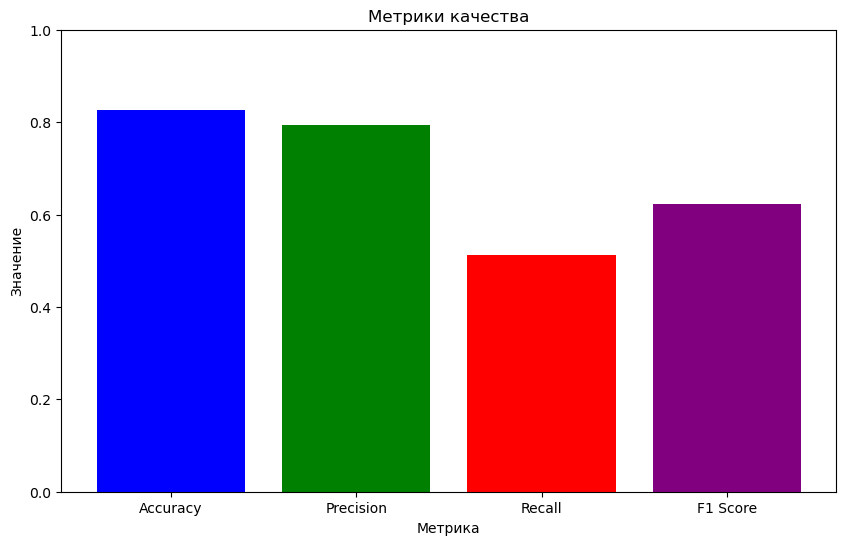

In [110]:
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Метрики качества')
plt.xlabel('Метрика')
plt.ylabel('Значение')
plt.ylim(0, 1)
plt.show()